# Predictive Churn Modeling and Risk Mitigation

---

## Project Overview
A telecom company wants to identify customers who are likely to churn so retention efforts can be applied before customers leave. **Customer churn represents a significant risk for subscription-based businesses**, where losing existing customers often has a greater financial impact than acquiring new ones.
This notebook analyzes customer churn behavior using historical customer data with three primary goals:
- Understand **which customers are most likely to churn**
- Identify **key behavioral, contractual, and pricing drivers**
- Translate analytical findings into **actionable retention strategies**

Machine learning models are used as **supporting tools**, with an emphasis on **interpretability and business insight** rather than pure predictive performance.

### Dataset
Telco Customer Churn Dataset

### Tools
Python, pandas, NumPy, scikit-learn, matplotlib, seaborn, SHAP

## Data Preparation and Cleaning

---

Before analysis, the dataset is prepared to ensure consistent, reliable inputs. This includes standardizing column names, handling missing values, encoding categorical variables, and validating key fields. These steps provide a clean foundation for exploration and modeling, without altering the underlying customer behavior.

In [15]:
# =========================
# Import Libraries
# =========================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import shap
import warnings
warnings.filterwarnings('ignore')

In [2]:
# =========================
# Load Dataset
# =========================
df = pd.read_csv("Telco-Customer-Churn.csv")

# Quick overview
print(df.head())
print(df.info())
print(df.describe())

   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies        Contract Pape

In [3]:
# =========================
# Data Cleaning & Preprocessing
# =========================

# Reload original dataset to ensure consistent baseline
df = pd.read_csv("Telco-Customer-Churn.csv")

# Standardize column names to lowercase for consistency
df.columns = df.columns.str.strip().str.lower()

# Handle missing totalcharges
if 'totalcharges' in df.columns:
    df['totalcharges'] = pd.to_numeric(df['totalcharges'], errors='coerce')
    df['totalcharges'].fillna(df['totalcharges'].median(), inplace=True)
else:
    raise KeyError("totalcharges column not found in dataset.")

# Drop ID column if present (safe)
for col in ['customerid', 'customer_id']:
    if col in df.columns:
        df.drop(columns=[col], inplace=True)

# Clean and encode target variable robustly
if 'churn' in df.columns:
    df['churn'] = df['churn'].astype(str).str.strip().str.lower()
    df = df[df['churn'].isin(['yes', 'no'])]
    df['churn'] = df['churn'].map({'yes': 1, 'no': 0})
else:
    raise KeyError("churn column not found")

# Encode categorical features (one-hot)
cat_cols = df.select_dtypes('object').columns.tolist()
if cat_cols:
    df = pd.get_dummies(df, columns=cat_cols, drop_first=True)

# Sanity check
print("Null values after cleaning:")
print(df.isna().sum().sort_values(ascending=False).head())
print("\nColumns after encoding:", len(df.columns))
display(df.head(2))

Null values after cleaning:
seniorcitizen                            0
onlinebackup_Yes                         0
paymentmethod_Electronic check           0
paymentmethod_Credit card (automatic)    0
paperlessbilling_Yes                     0
dtype: int64

Columns after encoding: 31


,seniorcitizen,tenure,monthlycharges,totalcharges,churn,gender_Male,partner_Yes,dependents_Yes,phoneservice_Yes,multiplelines_No phone service,...,streamingtv_No internet service,streamingtv_Yes,streamingmovies_No internet service,streamingmovies_Yes,contract_One year,contract_Two year,paperlessbilling_Yes,paymentmethod_Credit card (automatic),paymentmethod_Electronic check,paymentmethod_Mailed check
0,0,1,29.85,29.85,0,False,True,False,False,True,...,False,False,False,False,False,False,True,False,True,False
1,0,34,56.95,1889.50,0,True,False,False,True,False,...,False,False,False,False,True,False,False,False,False,True


In [4]:
# Verify key columns
print("Columns:", df.columns.tolist()[:10], "...\n")

print("Unique values in churn:", df['churn'].unique())
print("Churn value counts:")
print(df['churn'].value_counts(normalize=True).round(3))

Columns: ['seniorcitizen', 'tenure', 'monthlycharges', 'totalcharges', 'churn', 'gender_Male', 'partner_Yes', 'dependents_Yes', 'phoneservice_Yes', 'multiplelines_No phone service'] ...

Unique values in churn: [0 1]
Churn value counts:
churn
0    0.735
1    0.265
Name: proportion, dtype: float64


## Dataset Overview

---

The Telco Customer Churn dataset is a Kaggle resource for predicting customer attrition in telecom. It includes 7,043 customer records with 21 features: demographics (gender, SeniorCitizen, Partner, Dependents), services (phone, internet, streaming, security), account details (tenure, contract, billing, payment, charges), and binary churn label

## Exploratory Analysis: Understanding Churn Behavior

---

This exploratory analysis examines how **churn behavior varies across customer contracts, service types, pricing, and tenure**. Rather than focusing on individual metrics, the goal is to identify consistent patterns that distinguish customers who remain from those who leave. These trends help **early risk signals** and guide which factors warrant deeper modeling and interpretation in later sections.

Overall churn rate: 26.54%


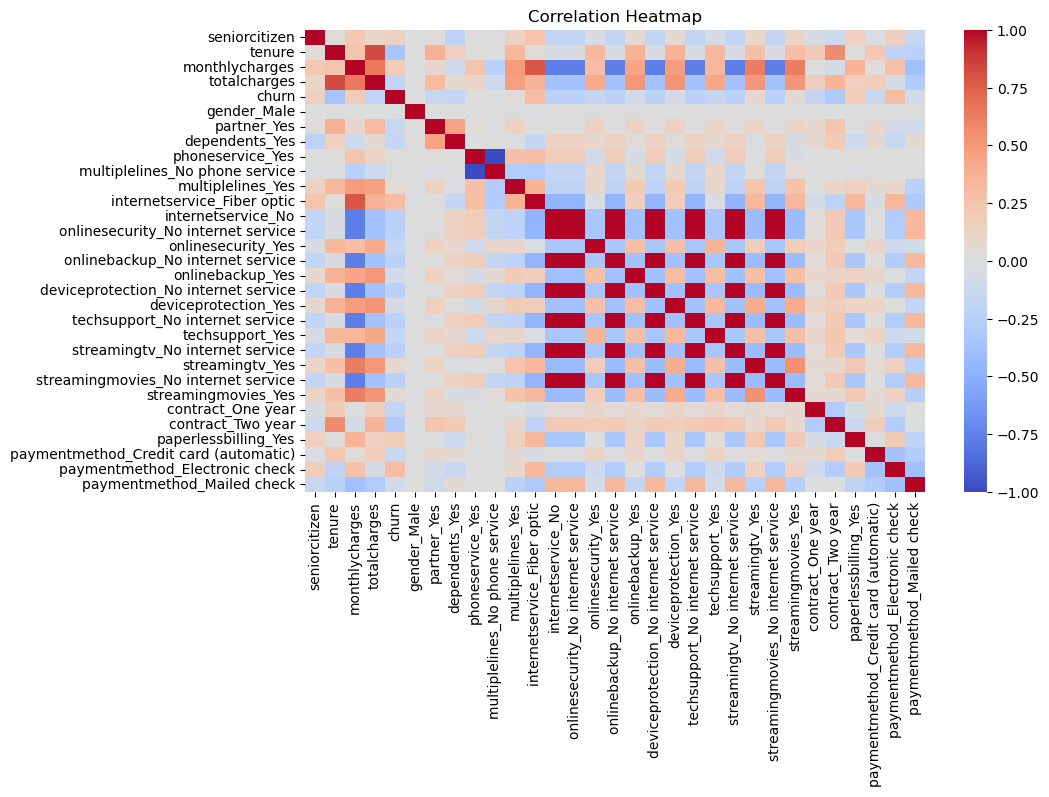

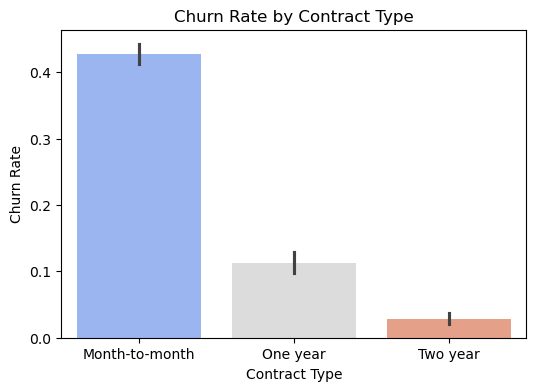

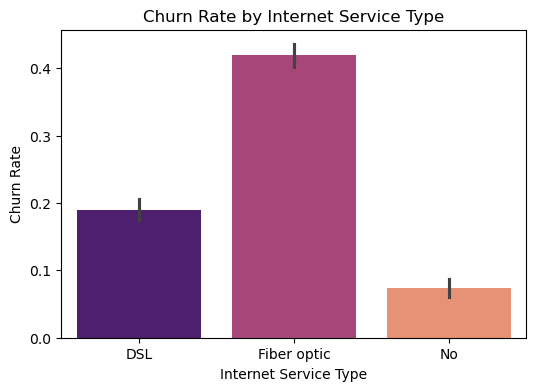

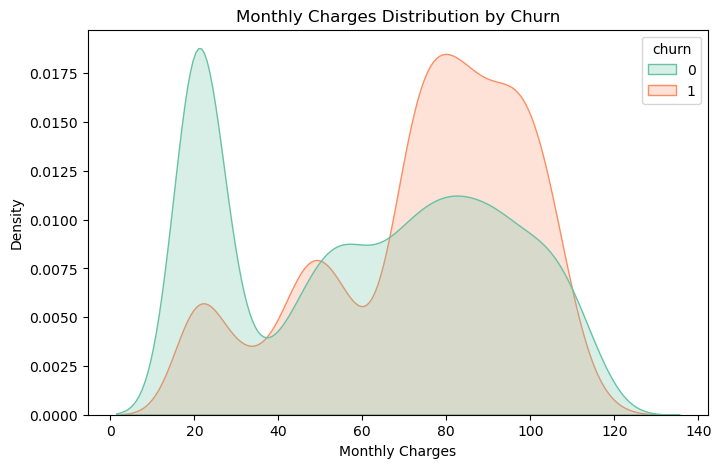

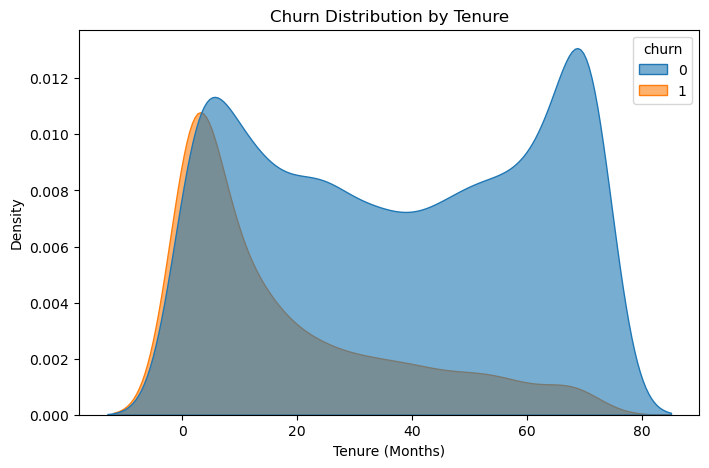

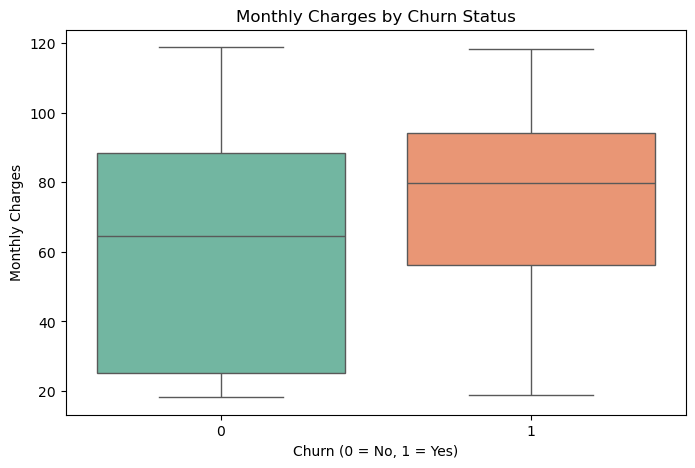

In [5]:
# =========================
# Exploratory Data Analysis
# =========================

# Overall churn rate
churn_rate = df['churn'].mean()
print(f"Overall churn rate: {churn_rate:.2%}")

# Correlation heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(), cmap='coolwarm', center=0)
plt.title("Correlation Heatmap")
plt.show()

# To plot churn rate by contract type and internet service,
# reload raw (unencoded) data for categorical labels
raw_df = pd.read_csv("Telco-Customer-Churn.csv")

# Standardize column names
raw_df.columns = raw_df.columns.str.lower().str.strip()

# Map churn values
raw_df['churn'] = raw_df['churn'].map({'Yes': 1, 'No': 0})

# --- Churn rate by contract type ---
plt.figure(figsize=(6, 4))
sns.barplot(x='contract', y='churn', data=raw_df, estimator='mean', palette='coolwarm')
plt.title("Churn Rate by Contract Type")
plt.ylabel("Churn Rate")
plt.xlabel("Contract Type")
plt.show()

# --- Churn rate by internet service ---
plt.figure(figsize=(6, 4))
sns.barplot(x='internetservice', y='churn', data=raw_df, estimator='mean', palette='magma')
plt.title("Churn Rate by Internet Service Type")
plt.ylabel("Churn Rate")
plt.xlabel("Internet Service Type")
plt.show()

# --- Monthly charges distribution by churn ---
plt.figure(figsize=(8, 5))
sns.kdeplot(data=raw_df, x='monthlycharges', hue='churn', fill=True, common_norm=False, palette='Set2')
plt.title("Monthly Charges Distribution by Churn")
plt.xlabel("Monthly Charges")
plt.ylabel("Density")
plt.show()

# --- Tenure vs. churn distribution ---
plt.figure(figsize=(8, 5))
sns.kdeplot(data=raw_df, x='tenure', hue='churn', fill=True, alpha=0.6)
plt.title("Churn Distribution by Tenure")
plt.xlabel("Tenure (Months)")
plt.ylabel("Density")
plt.show()

# --- Monthly charges vs. churn boxplot ---
plt.figure(figsize=(8, 5))
sns.boxplot(data=raw_df, x='churn', y='monthlycharges', palette='Set2')
plt.title("Monthly Charges by Churn Status")
plt.xlabel("Churn (0 = No, 1 = Yes)")
plt.ylabel("Monthly Charges")
plt.show()

## Key Insights from Exploratory Data Analysis
- **Churn affects about 26% of customers**, making retention a meaningful business issue rather than a marginal one.
- **Contract length strongly shapes churn behavior**. Month-to-month customers churn at roughly 40%, while long-term contracts are far more stable, indicating commitment is a key retention lever.
- **Fiber optic users churn at higher levels (~40%)**, suggesting value or expectation gaps compared to other service types.
- **Higher monthly charges are associated with higher churn**, implying that price increases amplify dissatisfaction rather than acting as the sole cause.
- **Churn is front-loaded in the customer lifecycle**. Risk is highest early on and declines sharply after the first year.
- **Additional services reduce churn**, indicating that bundled offerings increase perceived value and customer stickiness.

## Takeaway
Churn is concentrated among **early-tenure, higher-cost customers on flexible contracts**, especially fiber users. Retention efforts should focus on the first year, reinforcing value for higher-priced plans, and nudging customers toward longer commitments and bundled services.

In [6]:
# =========================
# Feature Engineering & Scaling
# =========================

# New features (lowercase names for consistency)
df['avgmonthlycost'] = df['totalcharges'] / (df['tenure'] + 1)
df['highcharges'] = (df['monthlycharges'] > df['monthlycharges'].median()).astype(int)

# Scale numerical columns
scaler = StandardScaler()
num_cols = ['tenure', 'monthlycharges', 'totalcharges', 'avgmonthlycost']
df[num_cols] = scaler.fit_transform(df[num_cols])

In [7]:
# =========================
# Train-Test Split
# =========================
X = df.drop('churn', axis=1)
y = df['churn']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [8]:
# =========================
# Train Baseline Models
# =========================

# Logistic Regression (baseline)
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)
y_pred_lr = log_reg.predict(X_test)

# Random Forest (baseline)
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("Baseline models trained. Sample predictions shapes:", y_pred_lr.shape, y_pred_rf.shape)

Baseline models trained. Sample predictions shapes: (1409,) (1409,)


In [9]:
# =========================
# Hyperparameter Tuning (Random Forest)
# =========================
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, 20],
    'min_samples_split': [2, 5]
}

grid = GridSearchCV(RandomForestClassifier(random_state=42),
                    param_grid, cv=3, scoring='recall', n_jobs=-1, verbose=0)
grid.fit(X_train, y_train)

best_rf = grid.best_estimator_
print("Best RF Parameters:", grid.best_params_)

# Predictions from tuned RF
y_pred_best = best_rf.predict(X_test)
print("=== Tuned Random Forest Report ===")
print(classification_report(y_test, y_pred_best))

Best RF Parameters: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 100}
=== Tuned Random Forest Report ===
              precision    recall  f1-score   support

           0       0.84      0.90      0.87      1035
           1       0.66      0.51      0.58       374

    accuracy                           0.80      1409
   macro avg       0.75      0.71      0.72      1409
weighted avg       0.79      0.80      0.79      1409



## Model Performance Comparison

---

To support the churn analysis, **two common classification models—Logistic Regression and Random Forest—are compared** to assess how reliably they **distinguish between customers who stay and those who leave**. The goal is not to maximize technical performance, but to choose **a model that balances accuracy, identifies at-risk customers** effectively, and remains easy to interpret for business use.


=== Model Performance Summary ===


,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC
0,Logistic Regression,0.811,0.684,0.537,0.602,0.847
1,Random Forest,0.786,0.627,0.481,0.545,0.824
2,Random Forest (Tuned),0.800,0.659,0.511,0.575,0.842


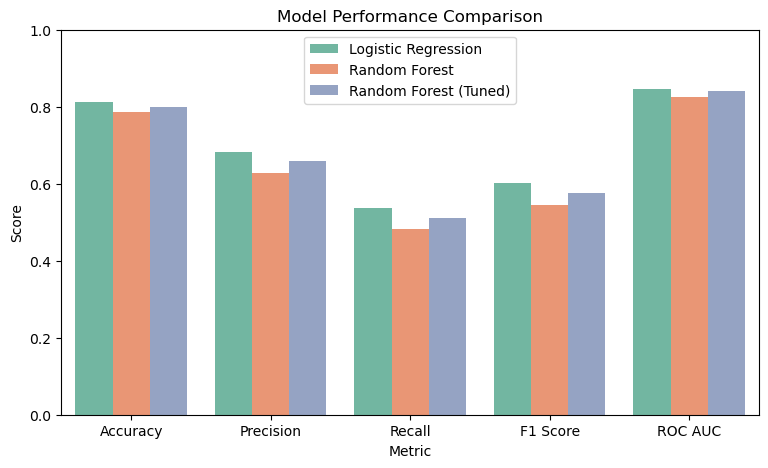

In [10]:
# =========================
# Model Comparison Summary
# =========================

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Prepare list of models and predictions
models = [
    ('Logistic Regression', log_reg, y_pred_lr),
    ('Random Forest', rf, y_pred_rf),
    ('Random Forest (Tuned)', best_rf, y_pred_best)
]

rows = []
for name, model_obj, y_pred in models:
    # compute score vector for ROC AUC where possible
    try:
        if hasattr(model_obj, "predict_proba"):
            y_scores = model_obj.predict_proba(X_test)[:, 1]
        elif hasattr(model_obj, "decision_function"):
            y_scores = model_obj.decision_function(X_test)
        else:
            y_scores = None
    except Exception:
        y_scores = None

    row = {
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred, zero_division=0),
        'Recall': recall_score(y_test, y_pred, zero_division=0),
        'F1 Score': f1_score(y_test, y_pred, zero_division=0),
        'ROC AUC': roc_auc_score(y_test, y_scores) if y_scores is not None else float('nan')
    }
    rows.append(row)

results_df = pd.DataFrame(rows)
print("\n=== Model Performance Summary ===")
display(results_df.round(3))

# Bar plot comparison
plt.figure(figsize=(9,5))
melted = results_df.melt(id_vars='Model', var_name='Metric', value_name='Score')
sns.barplot(data=melted, x='Metric', y='Score', hue='Model', palette='Set2')
plt.title("Model Performance Comparison")
plt.ylim(0,1)
plt.legend(title='')
plt.show()

## Key Insights: Model Performance Comparison
- **Logistic Regression performs slightly better overall than Random Forest** across accuracy, F1 score, and ROC AUC, indicating more consistent predictions.
- **Logistic Regression identifies more churned customers** correctly, with higher recall (about **54% vs 48%**), which is more important than marginal gains in accuracy for retention use cases.
- **The performance gap is modest**, but consistent, suggesting Logistic Regression generalizes better on this dataset.
- **Logistic Regression is easier to interpret**, making it more suitable for explaining churn drivers and supporting business decisions.

In [11]:
# =========================
# Data Integrity Checks
# =========================
print("X_train shape:", X_train.shape)
print("X_test shape :", X_test.shape)
print("Any object dtypes in X_train?", X_train.dtypes.apply(lambda t: t=='object').any())
print("Any object dtypes in X_test? ", X_test.dtypes.apply(lambda t: t=='object').any())

# Check nulls
print("\nX_train nulls (first 5):\n", X_train.isna().sum().sort_values(ascending=False).head())
print("X_test nulls (first 5):\n", X_test.isna().sum().sort_values(ascending=False).head())

X_train shape: (5634, 32)
X_test shape : (1409, 32)
Any object dtypes in X_train? False
Any object dtypes in X_test?  False

X_train nulls (first 5):
 seniorcitizen                     0
tenure                            0
avgmonthlycost                    0
paymentmethod_Mailed check        0
paymentmethod_Electronic check    0
dtype: int64
X_test nulls (first 5):
 seniorcitizen                     0
tenure                            0
avgmonthlycost                    0
paymentmethod_Mailed check        0
paymentmethod_Electronic check    0
dtype: int64


In [12]:
# =========================
# Align Numeric Features for SHAP
# =========================
X_train_num = X_train.apply(pd.to_numeric, errors='coerce').astype(float)
X_test_num  = X_test.apply(pd.to_numeric, errors='coerce').astype(float)
X_test_num = X_test_num.reindex(columns=X_train_num.columns, fill_value=0)
print("After coercion shapes:", X_train_num.shape, X_test_num.shape)

After coercion shapes: (5634, 32) (1409, 32)


## SHAP Analysis

---

**SHAP (SHapley Additive exPlanations)** is a method used to explain how a predictive model makes its decisions. It breaks down a prediction into the individual factors that push a customer’s churn risk higher or lower, relative to an average customer.
In this analysis, SHAP is used to **identify which customer attributes most consistently influence churn predictions**. Rather than treating the model as a black box, SHAP helps translate model behavior into clear, interpretable drivers that can be linked back to business actions.

X_sample shape: (200, 32)


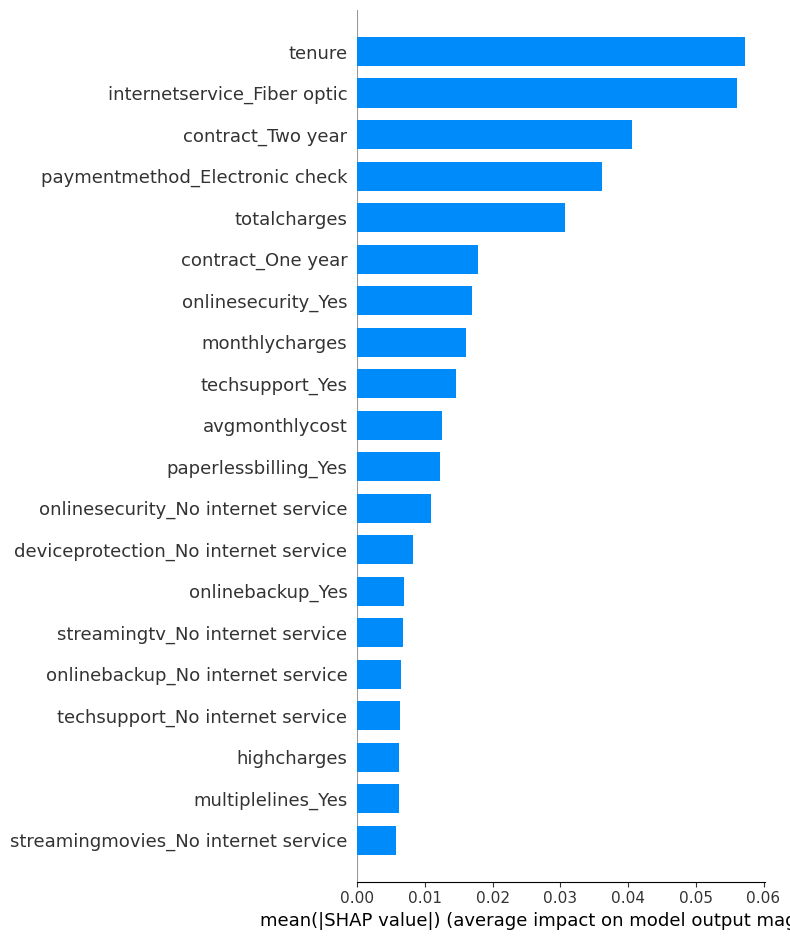

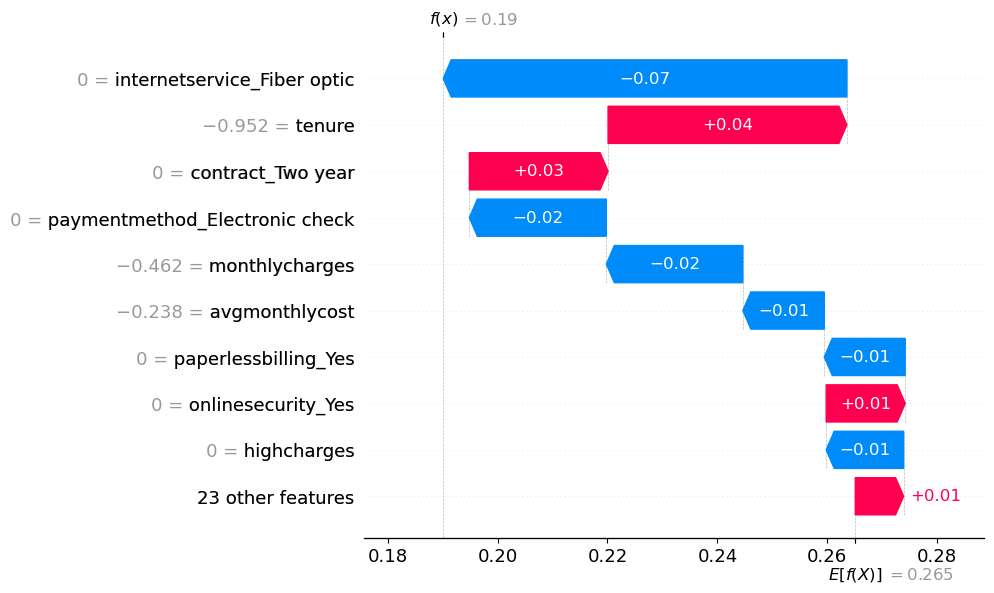

In [13]:
# =========================
# SHAP Analysis
# =========================

# Sample for faster SHAP computation
X_sample = X_test_num.sample(min(200, len(X_test_num)), random_state=42)
print("X_sample shape:", X_sample.shape)

# SHAP explainer
explainer = shap.TreeExplainer(best_rf)
shap_values_full = explainer.shap_values(X_sample)

# Select positive churn class (1)
class_index = 1 if shap_values_full.shape[-1] > 1 else 0
sv = shap_values_full[:, :, class_index]
assert sv.shape == X_sample.shape, "SHAP values shape mismatch"

# Summary bar plot
shap.summary_plot(sv, X_sample, plot_type="bar")

# Waterfall plot for first sample
base_value = explainer.expected_value[class_index] if isinstance(explainer.expected_value, (list, np.ndarray)) else explainer.expected_value
sample_idx = 0
sample = X_sample.iloc[sample_idx]

exp = shap.Explanation(
    values=sv[sample_idx],
    base_values=base_value,
    data=sample,
    feature_names=X_sample.columns
)
shap.plots.waterfall(exp)

## Key Insights: SHAP Analysis
SHAP analysis is used to **explain which factors most strongly influence churn predictions** across the customer base, ensuring the model’s outputs are interpretable and actionable.

Primary drivers of churn include:
- **Tenure**: Churn risk is highest for newer customers and declines steadily as relationships mature.
- **Contract type**: Longer-term contracts are associated with significantly lower churn.
- **Internet service**: Fiber optic customers show elevated churn risk compared to other service types.
- **Payment method**: Customers using electronic checks are more likely to churn than those on automatic payments.
- **Value-added services**: Features such as online security and technical support are linked to improved retention.

### Takeaway
The SHAP results reinforce earlier findings: **churn is driven by early customer lifecycle risk, contract flexibility, and perceived value**. By clearly identifying these drivers, the model supports targeted retention strategies rather than serving as a black-box predictor.

## Business Recommendations

---

1. **Win the first year or expect churn**
Churn is front-loaded. Invest aggressively in the first 90–180 days with guided onboarding, proactive check-ins, and early-stage incentives. Retention spend here delivers the highest return.
2. **Fix the fiber value gap**
Fiber customers churn more despite paying more. Treat this as a value perception problem: audit service reliability, simplify pricing, and bundle fiber plans with high-value add-ons (security, support) to justify the premium.
3. **Convert flexibility into commitment**
Month-to-month plans are the primary churn engine. Actively migrate these customers to 12–24 month contracts using targeted offers, loyalty pricing, or benefit upgrades tied to commitment.
4. **Eliminate payment friction**
Customers paying via electronic checks churn more. Push auto-pay adoption through default enrollment, small billing incentives, or simplified digital payment flows to reduce friction and increase stickiness.
5. **Protect high-revenue customers before they leave**
High monthly charges amplify churn risk. Flag these customers early and intervene with personalized bill reviews, loyalty perks, or plan optimization before dissatisfaction turns into exit.

## Final takeaway
**Churn is predictable, early, and preventable.**
The fix is not better models — it’s **forcing early engagement, enforcing commitment, and protecting high-value customers before dissatisfaction turns into exit.**